In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from numpy import random
import matplotlib.pyplot as plt
import itertools
from scipy.sparse.csgraph import shortest_path
from numpy import matlib
from sklearn.datasets import load_digits

In [43]:
def load_data():
    digits = load_digits()
    X, y = digits.data, digits.target
    X = X - np.mean(X, axis=0)
    DATA_MIN = np.floor(np.min(X))
    DATA_MAX = np.ceil(np.max(X))
    return X, y, DATA_MIN, DATA_MAX

def bootstrap_sample(n_sets,num_train_samples,len_data):
    data= []
    for i in range(n_sets):
        set_i = random.permutation(len_data)
        train_indices, test_indices = set_i[:num_train_samples], set_i[num_train_samples:] 
        data.append([train_indices, test_indices])
    return data

def get_leaf_classes(clf):
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    class_distribution = clf.tree_.value
    leaf_classes = []
    for i in range(n_nodes):
        if children_left[i] == -1:
            leaf_classes.append(np.argmax(class_distribution[i]))
    return leaf_classes

def calc_edge_lengths_from_dt(clf):
    n_nodes = clf.tree_.node_count
    thresholds = clf.tree_.threshold
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    lengths = np.ones(n_nodes)
    for i in range(n_nodes):
        if thresholds[i] != -2:
            left_edge_length = thresholds[i] - DATA_MIN
            right_edge_length = DATA_MAX - thresholds[i] #can use a more sophisticated calc if we want
            lengths[children_left[i]] = left_edge_length
            lengths[children_right[i]] = right_edge_length
    return lengths    

curr_leaf_num = 0
def build_newick_from_dt(clf, add_leaf_class_edges = False):
    global curr_leaf_num
    labels = [np.argmax(v) for v in clf.tree_.value]
    curr_leaf_num = 0
    children_left = clf.tree_.children_left #children_left[i] gives the id of the left child of node i
    children_right = clf.tree_.children_right
    lengths = calc_edge_lengths_from_dt(clf) #lengths[i] gives the length of the edge to node i from parent
    lengths[0] = 0
    represented_labels = []
    def build_newick_tree_rec(node_id):
        global curr_leaf_num
        left_child = children_left[node_id]
        right_child = children_right[node_id]
        if left_child == -1 and right_child == -1:
            if add_leaf_class_edges:
                class_distribution = clf.tree_.value[node_id][0]
                edge_weights = np.sum(class_distribution) - class_distribution
                leaf_str = "("
                for c in range(len(edge_weights)):
                    unique_class_id = 10 * curr_leaf_num + c 
                    leaf_str += "{}:{}".format(unique_class_id, edge_weights[c])
                    if c != len(edge_weights) - 1:
                        leaf_str += ","
                leaf_str += "):{}".format(lengths[node_id])
                curr_leaf_num  += 1
                return leaf_str     
            else:
                represented_labels.append(labels[node_id])
                return "{}:{}".format(labels[node_id], 1)
        else:
            left_str = build_newick_tree_rec(left_child)
            right_str = build_newick_tree_rec(right_child)
            if node_id == 0:
                return "({},{});".format(left_str, right_str)
            else:
                return "({},{}):{}".format(left_str, right_str, 1)
    final_nw = build_newick_tree_rec(node_id = 0)
    good = True
    if len(set(represented_labels)) != 10:
        good = False
    return final_nw, good

def find_good_trees(bootstrap_number):
    indices = bootstrap_sample(bootstrap_number,NUM_TRAIN,len(X))
    forest = []
    for i in range(bootstrap_number):
        Xtr = X[indices[i][0]]
        ytr = y[indices[i][0]]
        Xtst = X[indices[i][1]]
        ytst = y[indices[i][1]]
        dt = tree.DecisionTreeClassifier(max_leaf_nodes=10)
        dt = dt.fit(Xtr,ytr)
        nw, good = build_newick_from_dt(dt, add_leaf_class_edges=False)
        if good:
            forest.append([nw, dt, dt.score(Xtst,ytst)])
    return forest


def write_to_tree_dist_program_input():
    forest_test = find_good_trees(2500)
    nws, trees, scores = zip(*forest_test)
    print(min(scores), max(scores))
    scores = np.array(scores)
    nws = np.array(nws)
    trees = np.array(trees)
    sorted_idxs = np.argsort(scores)
    #bad_idxs = sorted_idxs[:5]
    #good_idxs = sorted_idxs[-5:]
    with open("gtp_170317/testing.txt", "w") as f:
        for i in sorted_idxs:
            f.write(nws[i])
            f.write('\n')
    print()
    return nws[sorted_idxs], trees[sorted_idxs], scores[sorted_idxs]

In [3]:
X, y, DATA_MIN, DATA_MAX = load_data()
NUM_TRAIN = int(len(X) * 0.50)

In [44]:
forest,trees,scores = write_to_tree_dist_program_input()

0.5850945494994438 0.710789766407119



In [460]:
len(scores)

514

Accuracy: 0.6729699666295884


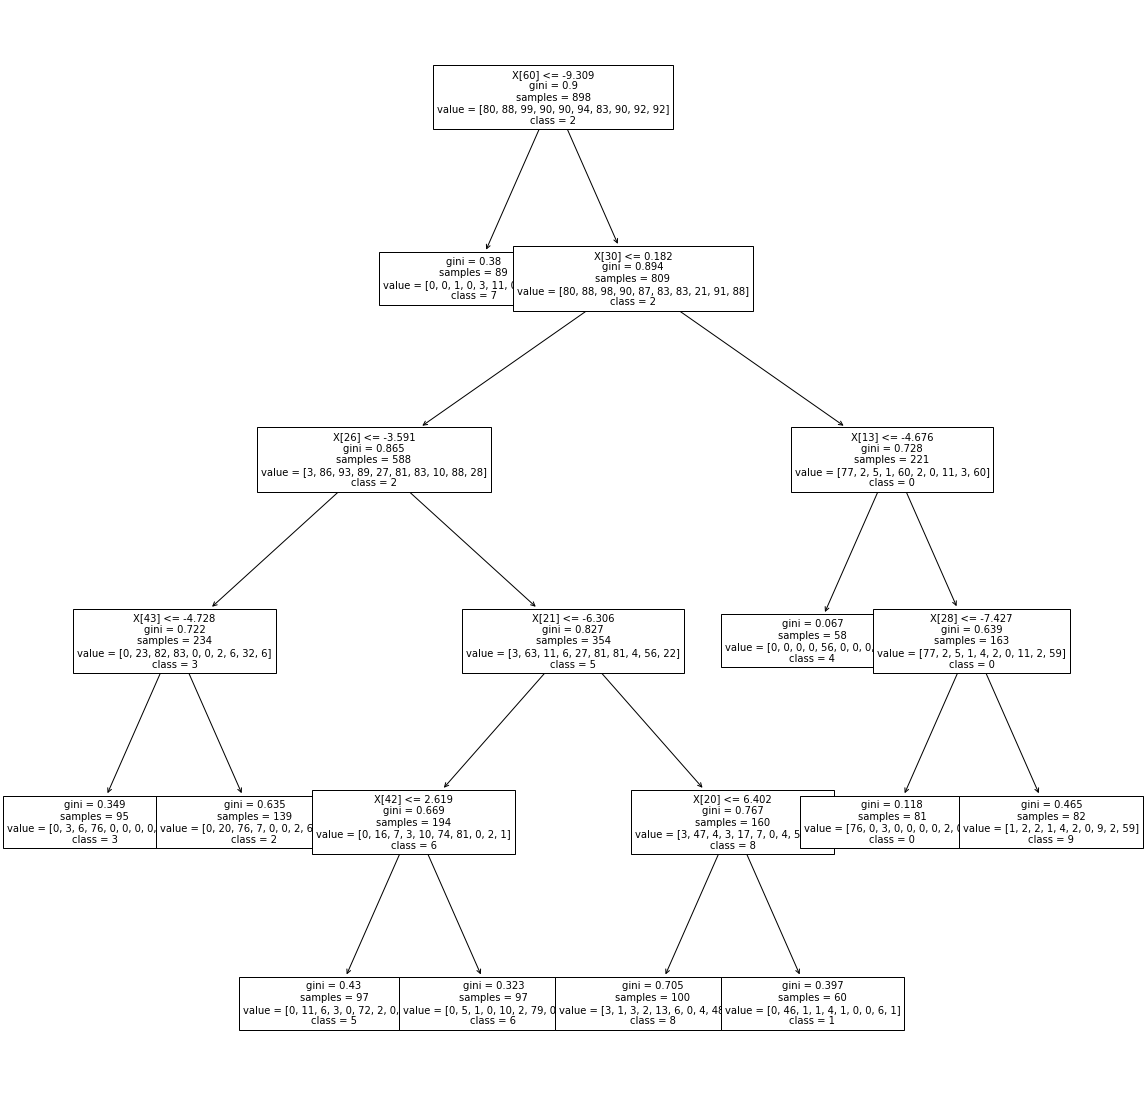

In [175]:
#Plots tree 
classes = ['0','1','2','3','4','5','6','7','8','9']
fig, ax1 = plt.subplots(figsize = (20,20))
tree.plot_tree(trees[tree_index], class_names = classes, fontsize = 10, ax = ax1) 
print('Accuracy: ' + str(scores[tree_index]))
plt.show()

In [45]:
file1 = open('treedists2.txt', 'r')
Lines = file1.readlines()

for i in range(len(Lines)):
    Lines[i] = Lines[i].strip().split('\t')
    
Lines = Lines[:-1]

In [48]:
int(Lines[-1][1])+1

564

In [49]:
adj = np.zeros((564,564))

In [50]:
for line in Lines:
    if len(line) != 1:
        adj[int(line[0])][int(line[1])] = float(line[2])
        adj[int(line[1])][int(line[0])] = float(line[2])

In [51]:
min_trees = (0,0)
dist = 1000
for line in Lines:
    if len(line) > 1:
        if float(line[2]) < dist:
            dist = float(line[2])
            min_trees = (int(line[0]),int(line[1]))

In [52]:
min_trees

(1, 7)

In [53]:
def euclidean_distance(x1,x2):
    total = 0
    for i in range(len(x1)):
        total += np.square(x1[i]-x2[i])
    return math.sqrt(total)

In [54]:
class single_linkage:
    def __init__(self, epsilon):
        self.epsilon = epsilon 
    
    def fit(self,dist_mat):
        self.adjacency = self.get_adjacency(dist_mat)
        self.clusters, self.k = self.get_clusters()
        
    def get_adjacency(self,dist_mat):
        adj = np.zeros((len(dist_mat),len(dist_mat)))
        for i in range(len(dist_mat)-1):
            for j in range(i+1,len(dist_mat)):
                distance = dist_mat[i][j]
                if (distance < 2*self.epsilon):
                    adj[i][j] = 1
                    adj[j][i] = 1       
        return adj 
    
    def get_clusters(self):
        clusters = []
        num_clusters = 0 
        for i in range(len(self.adjacency[0])):
            in_cluster = False
            for c in clusters:
                if np.count_nonzero(c == i)!= 0:
                    in_cluster = True
            if in_cluster == False:
                num_clusters += 1
                new_cluster = np.array([i])
                for j in range(len(self.adjacency[0])):
                    if (i != j) and (np.count_nonzero(new_cluster == j) == 0):
                        if self.adjacency[i][j] == 1:
                            new_cluster = np.concatenate((new_cluster,self.cluster_from(j,new_cluster)),axis=0)
                clusters.append(new_cluster)
        return clusters, num_clusters 
        
    def cluster_from(self, x, clust):
        direct_connect = np.array([x])
        above = np.concatenate((direct_connect,clust),axis=0)
        for i in range(len(self.adjacency[0])):
            if (np.count_nonzero(above == i) == 0):
                if (self.adjacency[x][i] == 1):
                    direct_connect = np.concatenate((direct_connect,self.cluster_from(i,above)),axis=0)
                    above = np.concatenate((direct_connect,above),axis=0)
        return direct_connect
        
        
        return clusters, num_clust

In [55]:
class spectral_clustering:
    
    def __init__(self, k_nearest, k_means,distance_func, bandwidth):
        self.k_nearest = k_nearest #-1 if you want gaussian damped weights in adjacency matrix
        self.k_ms = k_means #number of clusters 
        self.dist = distance_func #metric
        self.var = bandwidth #sigma squared for gaussian damped weights
        
    def fit(self,X,target_dim):
        L = self.get_laplacian(X)
        self.transformed_data = self.get_transformed(L,target_dim)
        self.run_kmeans = k_means(self.k_ms,0.0001,100)
        self.run_kmeans.fit(self.transformed_data,self.dist)
        self.clusters = self.run_kmeans.clusters
        
    def get_laplacian(self, X):
        W = self.get_adjacency_weighted(X) if (self.k_nearest == -1) else self.get_adjacency_k_nearest(X)
        D = self.get_degree(X,W)
        return np.subtract(D,W)
        
    def get_adjacency_k_nearest(self,X):
        adj = np.zeros((len(X),len(X)))
        for i in range(len(X)):
            dtype = [('point', int), ('dist', float)]
            vals = []
            for j in range(len(X)):
                if (j != i):
                    distance = X[i][j]
                    vals.append((j,distance))
            a = np.array(vals, dtype=dtype)
            ascending = np.sort(a, order='dist') 
            for k in range(self.k_nearest):
                neighbor = tuple(ascending[k])[0]
                distance = tuple(ascending[k])[1]
                #weight = math.exp(-(distance**2)/(2*self.var))
                adj[i][neighbor] = 1
                adj[neighbor][i] = 1
        print(adj)
        return adj 
    
    def get_adjacency_weighted(self,X):        
        X_list = X.values.tolist()
        adj = np.zeros((len(X),len(X)))
        for i in range(len(X)-1):
            for j in range(i+1,len(X_list)):
                distance = self.dist(X_list[i],X_list[j])
                weight = m.exp(-(distance**2)/(2*self.var))
                adj[i][j] = weight
                adj[j][i] = weight      
        return adj 
    
    
    def get_degree(self,X,W):
        deg = np.zeros((len(X),len(X)))
        for i in range(len(X)):
            deg[i][i] = np.sum(W[i])
        return deg
    
    def get_transformed(self,laplacian,target):
        evals, evecs = np.linalg.eig(laplacian)
        evecs2 = evecs[:,np.argsort(evals)]
        self.evals = evals[np.argsort(evals)]
        new_d = evecs2[:,:target]
        dims = []
        self.new_d = new_d
        for num in np.linspace(1,target,target,dtype='int32').tolist():
            dims.append(str(num))
        return pd.DataFrame(new_d, columns = dims)

In [56]:
class k_means:
    def __init__(self, k, epsilon, max_iter):
        self.k = k
        self.epsilon = epsilon 
        self.max_iter = max_iter
        
    def fit(self,X, distance_func):
        self.centroids = self.initial_centroids(X)
        self.initial_centroids = self.centroids
        iteration = 0
        for i in range(self.max_iter):
            iteration += 1
            clusters = self.get_clusters(X,distance_func)
            new_centroids = self.get_centroids(clusters,X)
            terminate = self.stopping_condition_check(new_centroids,distance_func)
            self.centroids = new_centroids
            if terminate == True:
                break
        if terminate == True:
            print("Terminated from stopping condition after "+ str(iteration) +" iterations.")
        else:
            print("Terminated from reaching max_iter")
        self.clusters = clusters
               
    def initial_centroids(self,X):
        centroid_index = random.permutation(len(X.index))[:self.k]
        centroids = []
        X_list = X.values.tolist()
        for index in centroid_index:
            centroids.append(X_list[index])
        return centroids
    
    def get_clusters(self,X,distance_func):
        clusters = np.multiply(np.ones((self.k,len(X.index))),-1)
        X_list = X.values.tolist()
        for n in range(len(X_list)):
            distances = []
            for k in range(self.k):
                distances.append(distance_func(X_list[n],self.centroids[k]))
            if len(np.where(np.array(distances) == np.amin(distances))[0]) > 1:
                where_min = np.where(np.array(distances) == np.amin(distances))[0][0]
            else:
                where_min = np.where(np.array(distances) == np.amin(distances))[0]
            cluster = int(where_min)
            clusters[cluster,int(np.where(clusters[cluster,:] == -1)[0][0])] = n
        return clusters
            
    def get_centroids(self,clusters,X):
        centroids = []
        X_list = X.values.tolist()
        for i in range(self.k):
            cluster_i = clusters[i,:]
            tot = np.zeros(len(X_list[0]))
            if self.k == 1:
                where = len(cluster_i)
            else:
                where = np.where(cluster_i == -1)[0][0]
            for j in range(int(where)):
                tot = np.add(tot,X_list[int(cluster_i[j])])
            avg = tot/int(where)     
            centroids.append(avg)
        return centroids
    
    def stopping_condition_check(self,new_centroids,dist):
        sat = 0
        for i in range(self.k):
            distance = dist(new_centroids[i],self.centroids[i])
            if (distance <= self.epsilon):
                sat += 1
        if (sat == self.k):
            return True
        return False


In [57]:
class mds:
    
    def __init__(self,target_dim):
        self.d = target_dim
        
    def fit(self, M, raw):
        self.raw = raw
        if self.raw == True:
            dist_mat = get_dist_squared_adj(M)
        else:
            dist_mat = M
        N = self.kernel(dist_mat)
        self.transformed = self.get_transformed(N)
        
    def kernel(self,M):
        #Applies a transformation to the desired matrix
        H = np.identity(len(M))-(1/len(M))
        S = np.square(M)
        kern = (-1/2)*np.matmul(H,np.matmul(S,H))
        return kern
    
    def get_transformed(self,M):
        evals, evecs = np.linalg.eig(M)
        ranked = np.argsort(evals)
        descending = ranked[::-1][:self.d]
        evecs2 = evecs[:,descending]
        self.evals = evals[descending]
        new_d = evecs2[:,:self.d]
        evals_mat = np.sqrt(np.diag(self.evals))
        return np.matmul(new_d,evals_mat)
    
    def get_dist_squared_adj(self,X):        
        adj = np.zeros((len(X),len(X)))
        for i in range(len(X)-1):
            for j in range(i+1,len(X)):
                distance = self.dist(X[i],X[j])
                adj[i][j] = distance**2
                adj[j][i] = distance**2    
        return adj 

In [58]:
class isomap:
    
    def __init__(self, k_nearest,epsilon,distance_func):
        self.k_nearest = k_nearest #-1 if you want gaussian damped weights in adjacency matrix
        self.epsilon = epsilon
        self.dist = distance_func #metric
        
    def fit(self,X,target_dim):
        G = self.to_graph(X)
        self.G_prime = self.shortest_paths(G)
        self.transformed = self.get_mds(target_dim)
        
    def get_mds(self,target_dim):
        helper = mds(target_dim)
        helper.fit(self.G_prime, raw=False)
        return helper.transformed
    
    def residual_variance(self):
        kern_old = self.kernel(self.G_prime)
        kern_new = self.kernel(self.get_adjacency(self.transformed))
        err = np.linalg.norm(np.subtract(kern_old,kern_new), ord='fro')*(1/len(self.G_prime))
        self.rv = err
    
    def to_graph(self,X):
        if self.k_nearest == -1:
            adj = self.get_adjacency_eps(X)
        else:
            adj = self.get_adjacency_k_nearest(X)
        return adj
    
    def get_adjacency(self,X):        
        adj = np.zeros((len(X),len(X)))
        for i in range(len(X)-1):
            for j in range(i+1,len(X)):
                distance = self.dist(X[i],X[j])
                adj[i][j] = distance
                adj[j][i] = distance      
        return adj 
        
    def get_adjacency_k_nearest(self,X):
        adj = np.zeros((len(X),len(X)))
        for i in range(len(X)):
            dtype = [('point', int), ('dist', float)]
            vals = []
            for j in range(len(X)):
                if (j != i):
                    distance = X[i][j]
                    vals.append((j,distance))
            a = np.array(vals, dtype=dtype)
            ascending = np.sort(a, order='dist') 
            for k in range(self.k_nearest):
                neighbor = tuple(ascending[k])[0]
                distance = tuple(ascending[k])[1]
                adj[i][neighbor] = distance
                adj[neighbor][i] = distance
        return adj 
    
    def get_adjacency_weighted(self,X):        
        adj = np.zeros((len(X),len(X)))
        for i in range(len(X)-1):
            for j in range(i+1,len(X)):
                distance = self.dist(X[i],X[j])
                weight = distance if (distance <= self.epsilon) else sys.maxsize
                adj[i][j] = weight
                adj[j][i] = weight
        for i in range(len(X)-1):
            adj[i][i] = 0
        return adj 
    
    def shortest_paths(self,G):
        #Floyd's Algorithm or dijkstras algo
        #I had implemented this myself but it was extremely slow
        return shortest_path(G, method='D', directed=False)
    
    def kernel(self,M):
        #Applies a transformation to the desired matrix
        H = np.identity(len(M))-(1/len(M))
        S = np.square(M)
        kern = (-1/2)*np.matmul(H,np.matmul(S,H))
        return kern

In [85]:
def get_adjacency(X):        
        adj = np.zeros((len(X),len(X)))
        for i in range(len(X)-1):
            for j in range(i+1,len(X)):
                distance = np.linalg.norm(X[i]-X[j])
                adj[i][j] = distance
                adj[j][i] = distance      
        return adj 

In [68]:
#Try Isomap on the trees 
test = isomap(48,0,euclidean_distance)
test.fit(adj,3)

/Users/liamsantacruz/miniconda3/envs/python_env/lib/python3.6/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/liamsantacruz/miniconda3/envs/python_env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/liamsantacruz/miniconda3/envs/python_env/lib/python3.6/site-packages/matplotlib/colors.py:271: ComplexWarning: Casting complex values to real discards the imaginary part
  c = tuple(map(float, c))


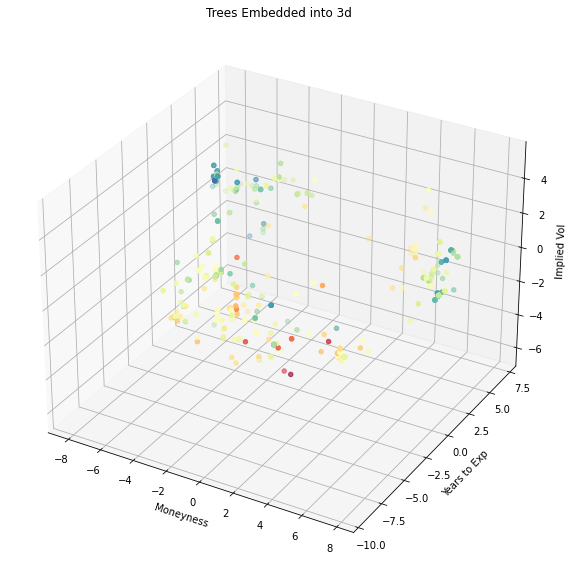

In [69]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(test.transformed[:,0],test.transformed[:,1], test.transformed[:,2], marker='o', c=scores,cmap=plt.cm.Spectral )

ax.set_xlabel('Moneyness')
ax.set_ylabel('Years to Exp')
ax.set_zlabel('Implied Vol')
ax.set_title('Trees Embedded into 3d')

plt.show()

Text(0.5, 1.0, 'Isomap kn= 25. Color Corresponds to accuracy')

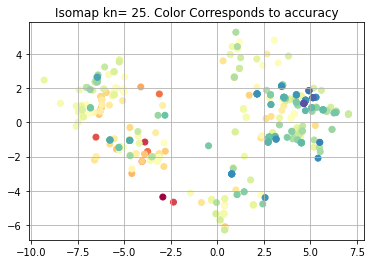

In [70]:
fig, ax = plt.subplots()
ax.scatter(test.transformed[:,1], test.transformed[:,2], c=scores, cmap=plt.cm.Spectral)
ax.grid()
plt.title('Isomap kn= 25. Color Corresponds to accuracy')
#plt.savefig('sparse_swiss_iso_k4')

In [86]:
#Spectral Clustering on Isomap Embedding 
adjacency_iso = get_adjacency(test.transformed)

In [90]:
#Spectral Clustering
spectral_trees = spectral_clustering(10,5,euclidean_distance,5)
spectral_trees.fit(adjacency_iso,2)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
Terminated from stopping condition after 3 iterations.


/Users/liamsantacruz/miniconda3/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


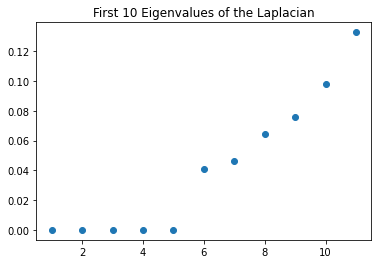

In [91]:
evals = spectral_trees.evals
plt.scatter(np.linspace(1,11,11),evals[:11])
plt.title('First 10 Eigenvalues of the Laplacian')
plt.savefig('First 10 Eigenvalues of the Laplacian')

<AxesSubplot:xlabel='1', ylabel='2'>

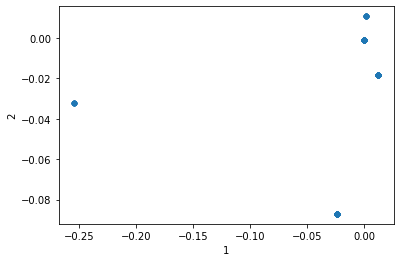

In [89]:
spectral_trees.transformed_data.plot.scatter(x='1',y='2')

In [92]:
spectral_clusters = spectral_trees.clusters

In [93]:
new_spectral_clusters = []
for i in range(len(spectral_clusters)):
    clust = []
    for j in range(len(spectral_clusters[i])):
        if spectral_clusters[i][j] > -1:
            clust.append(int(spectral_clusters[i][j]))
    new_spectral_clusters.append(np.array(clust))

In [96]:
def random_tree_fromdata(X, y):
    # random gaussian array of shape X.shape with values between pix_min and pix_max
    X_rand = np.random.randn(*X.shape) * 3

    # random list of digits between 0 and 9
    y_rand = np.random.randint(0, 10, y.shape[0])
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)
    clf = clf.fit(X_rand,y_rand)

    nw = build_newick_from_dt(clf, match_class_leaves=True)
    return nw

In [284]:
#Single Linkage Clusters
eps = np.linspace(30,40,200)

In [290]:
num_clusts = []
means_e = []
for e in eps:
    sl_test = single_linkage(epsilon = e)
    sl_test.fit(adj)
    mean_d = []
    for c in sl_test.clusters:
        dists = []
        pairs = np.array(list(itertools.combinations(set(c), 2)))
        for pair in pairs:
            dists.append(adj[pair[0]][pair[1]])
        if len(dists) > 0:
            mean_d.append(np.mean(dists))
        #else:
        #    mean_d.append(0.0)
    means_e.append(np.mean(mean_d))
    num_clust = len(sl_test.clusters)
    num_clusts.append(num_clust)

Text(0, 0.5, '# Clusters')

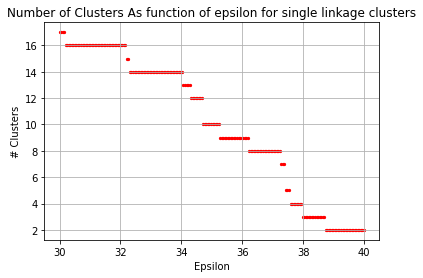

In [291]:
plt.scatter(eps,num_clusts, s=5,c='r')
plt.grid()
plt.title('Number of Clusters As function of epsilon for single linkage clusters')
plt.xlabel('Epsilon')
plt.ylabel('# Clusters')
#plt.savefig('Graphs Hw4/clusters_v_eps')

Text(0, 0.5, 'Average inter tree distance')

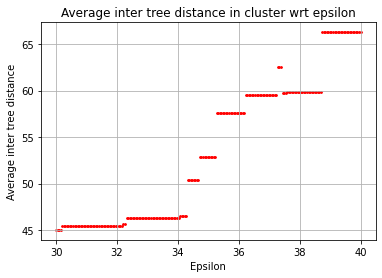

In [292]:
plt.scatter(eps,means_e, s=3,c='r')
plt.grid()
plt.title('Average inter tree distance in cluster wrt epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Average inter tree distance')
#plt.savefig('Graphs Hw4/clusters_v_eps')

In [420]:
single_linkage_test = single_linkage(epsilon = 37.38693467336684)
single_linkage_test.fit(adj)
clusters = single_linkage_test.clusters

In [344]:
ind = 147
eps[ind],means_e[ind],num_clusts[ind]

(37.38693467336684, 62.577857172802155, 7)

In [283]:
clusters

[array([  0,   1,  19,  45,  60,  30, 112,  27,   3,   4,   6,  16,  22,
         23,  26,  28,  56,  41,  13,   5,  93,  36,  32,  35,  42,  34,
         40,  47,  48,  52,  50,  59,  54,  65,  64,  66,  70,  68,  69,
         73,  75,  83,  85,  86,  88,  97,  98, 101, 102, 103, 110, 113,
        118,  72,  14,  11,   2,  20,   7,  12,  33,  39,  49,  53,  29,
         31,  44,  51,  55,  71,  78,  80,  82,  95, 104,  18,  17,  21,
         24,  43,  46,  57,  61,  62,  63,  87,  89]),
 array([ 8,  9, 15, 25, 37, 58, 67, 81]),
 array([10]),
 array([ 38,  76,  77,  79,  84,  90,  91,  92,  94,  96,  99, 100, 105,
        107, 106, 109, 108, 111, 114, 115, 116, 117, 119, 120, 121, 122]),
 array([74])]

In [412]:
def print_cluster_diagnostics(clusters):
    clusters_info = []
    for cluster in clusters:
        cluster_score = []
        for tree_index in cluster:
            cluster_score.append(scores[tree_index])
        clusters_info.append(cluster_score)
        
    mean_d = []
    for c in clusters:
        dists = []
        pairs = np.array(list(itertools.combinations(set(c), 2)))
        for pair in pairs:
            dists.append(adj[pair[0]][pair[1]])
        mean_d.append(np.mean(dists))
        
    for i in range(len(clusters_info)):
        print('Clust: ' + str(i))
        print('Num Trees: ' + str(len(clusters_info[i])))
        print('Avg Distance Between Trees: ' + str(mean_d[i]) )
        print('Mean Acc: '+ str(np.mean(clusters_info[i])))
        print('Std Acc: ' +str(np.std(clusters_info[i])) + '\n')

In [422]:
new_spectral_clusters

[array([  2,   7,   8,   9,  11,  12,  14,  15,  17,  18,  20,  21,  24,
         25,  29,  31,  33,  37,  39,  43,  44,  45,  46,  49,  51,  53,
         55,  57,  58,  61,  62,  63,  67,  71,  72,  74,  78,  80,  81,
         82,  87,  89,  95, 104]),
 array([ 10,  38,  76,  77,  79,  84,  90,  91,  92,  94,  96,  99, 100,
        105, 106, 107, 108, 109, 111, 114, 115, 116, 117, 119, 120, 121,
        122]),
 array([ 0,  1,  3,  4,  6, 16, 19, 22, 23, 26, 27, 28, 30, 56]),
 array([  5,  13,  32,  34,  35,  36,  40,  41,  42,  47,  48,  50,  52,
         54,  59,  60,  64,  65,  66,  68,  69,  70,  73,  75,  83,  85,
         86,  88,  93,  97,  98, 101, 102, 103, 110, 112, 113, 118])]

In [423]:
clusters

[array([  0,   1,  19,  45,  60,  30, 112]),
 array([  2,  11,  14,  21,  24,  43,  46,  57,  61,  62,  63,  72,  87,
         89,  29,   7,  12,  20,  33,  39,  49,  53,  44,  31,  51,  55,
         71,  78,  80,  82,  95, 104,  18,  17]),
 array([  3,   4,   6,  16,  22,  23,  26,  27,  28,  56,  41,  13,   5,
         93,  36,  32,  35,  42,  34,  40,  47,  48,  52,  50,  59,  54,
         65,  64,  66,  70,  68,  69,  73,  75,  83,  85,  86,  88,  97,
         98, 101, 102, 103, 110, 113, 118]),
 array([ 8,  9, 15, 25, 37, 58, 67, 81]),
 array([10]),
 array([ 38,  76,  77,  79,  84,  90,  91,  92,  94,  96,  99, 100, 105,
        107, 106, 109, 108, 111, 114, 115, 116, 117, 119, 120, 121, 122]),
 array([74])]

In [489]:
print_cluster_diagnostics(new_spectral_clusters)

Clust: 0
Num Trees: 153
Avg Distance Between Trees: 62.1904691621087
Mean Acc: 0.6669211251426784
Std Acc: 0.015551464364803078

Clust: 1
Num Trees: 120
Avg Distance Between Trees: 62.81809252941176
Mean Acc: 0.6797182054134223
Std Acc: 0.016304982605635076

Clust: 2
Num Trees: 126
Avg Distance Between Trees: 85.23586273396825
Mean Acc: 0.6485689566890901
Std Acc: 0.015411059583867735

Clust: 3
Num Trees: 115
Avg Distance Between Trees: 77.23310855530129
Mean Acc: 0.6620109300188615
Std Acc: 0.01630410210942372



In [421]:
print_cluster_diagnostics(clusters)

Clust: 0
Num Trees: 7
Avg Distance Between Trees: 80.00463333333335
Mean Acc: 0.6451612903225806
Std Acc: 0.027932348549050513

Clust: 1
Num Trees: 34
Avg Distance Between Trees: 74.76453538324421
Mean Acc: 0.6569717987306157
Std Acc: 0.017272515289422634

Clust: 2
Num Trees: 46
Avg Distance Between Trees: 64.548427294686
Mean Acc: 0.6623784881752673
Std Acc: 0.018677667731126096

Clust: 3
Num Trees: 8
Avg Distance Between Trees: 43.537900714285705
Mean Acc: 0.6511401557285874
Std Acc: 0.01619542069407249

Clust: 4
Num Trees: 1
Avg Distance Between Trees: nan
Mean Acc: 0.6318131256952169
Std Acc: 0.0

Clust: 5
Num Trees: 26
Avg Distance Between Trees: 50.03378913846154
Mean Acc: 0.6854196970993413
Std Acc: 0.009882034882075015

Clust: 6
Num Trees: 1
Avg Distance Between Trees: nan
Mean Acc: 0.6729699666295884
Std Acc: 0.0



Clust: 0
Num Trees: 87
Avg Distance Between Trees: 85.521334723336
Mean Acc: 0.6588802373007043
Std Acc: 0.019668705523064607

Clust: 1
Num Trees: 8
Avg Distance Between Trees: 43.537900714285705
Mean Acc: 0.6511401557285874
Std Acc: 0.01619542069407249

Clust: 2
Num Trees: 1
Avg Distance Between Trees: nan
Mean Acc: 0.6318131256952169
Std Acc: 0.0

Clust: 3
Num Trees: 26
Avg Distance Between Trees: 50.03378913846154
Mean Acc: 0.6854196970993413
Std Acc: 0.009882034882075015

Clust: 4
Num Trees: 1
Avg Distance Between Trees: nan
Mean Acc: 0.6729699666295884
Std Acc: 0.0



Accuracy: 0.60734149054505


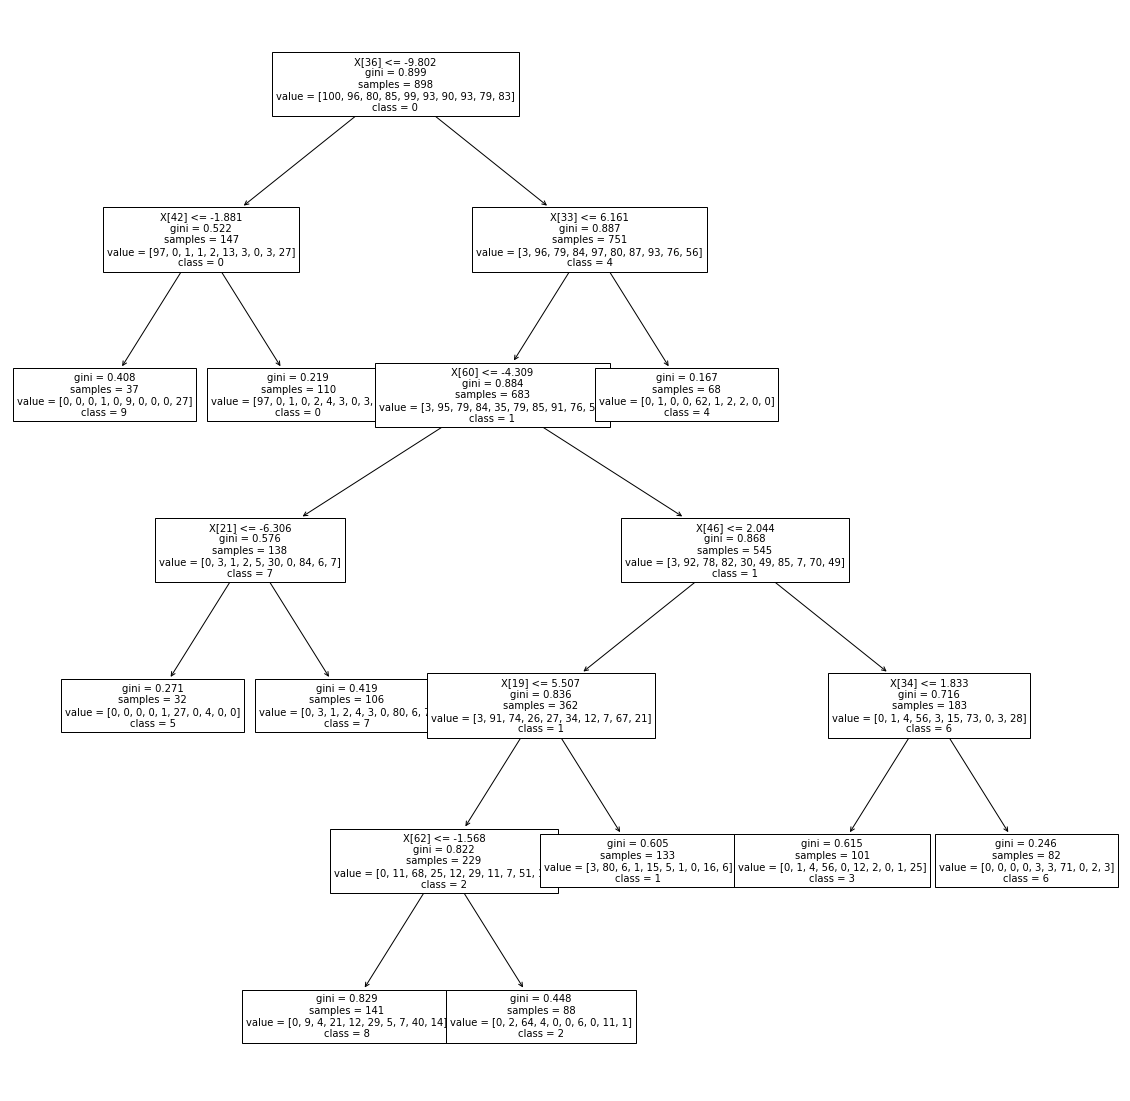

In [424]:
#Plots tree
tree_index = 0
classes = ['0','1','2','3','4','5','6','7','8','9']
fig, ax1 = plt.subplots(figsize = (20,20))
tree.plot_tree(trees[tree_index], class_names = classes, fontsize = 10, ax = ax1) 
print('Accuracy: ' + str(scores[tree_index]))
plt.show()

Accuracy: 0.6229143492769744


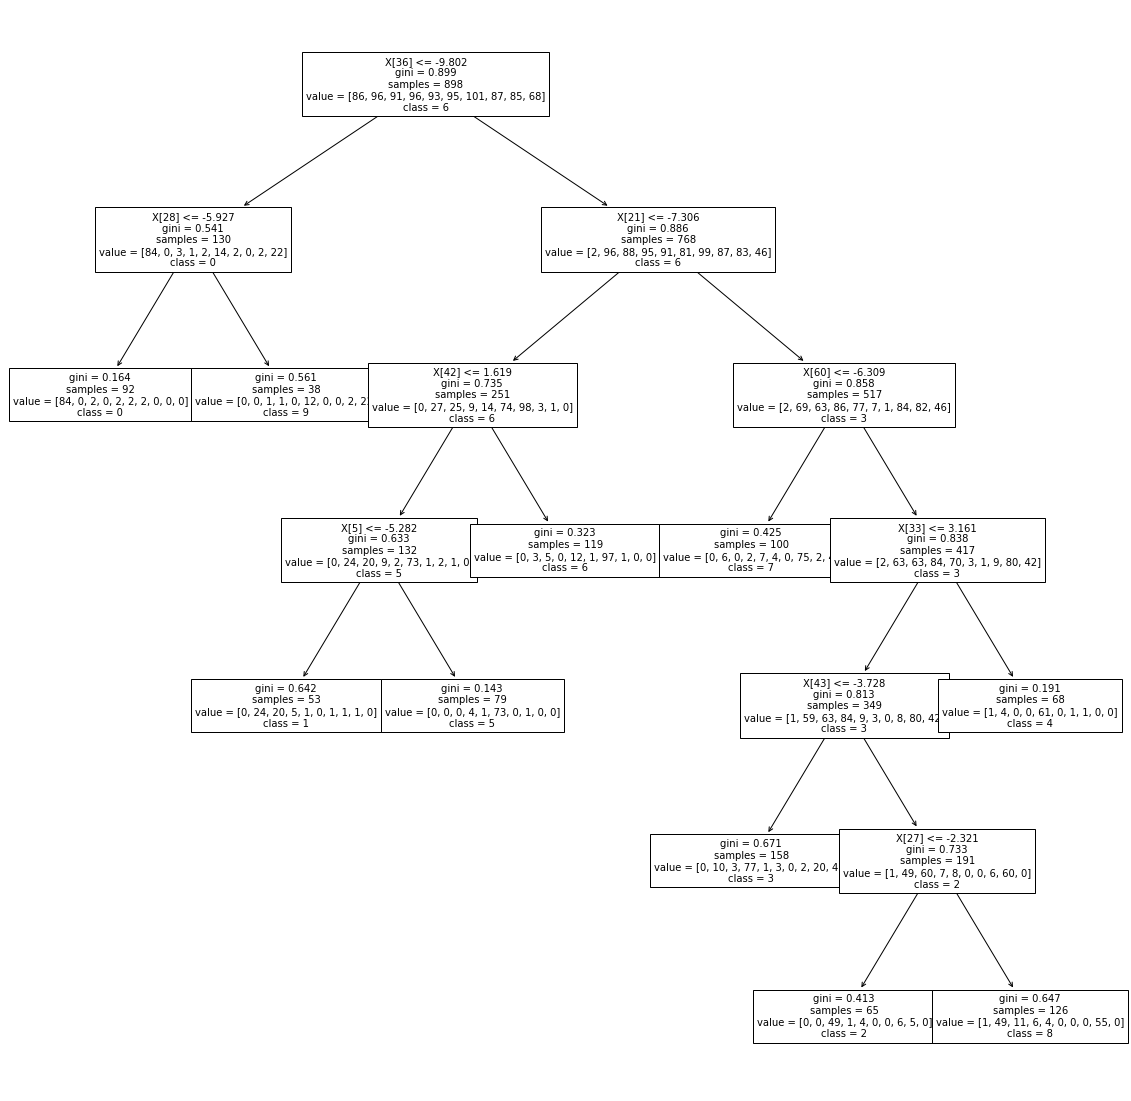

In [425]:
#Plots tree
tree_index = 3
classes = ['0','1','2','3','4','5','6','7','8','9']
fig, ax1 = plt.subplots(figsize = (20,20))
tree.plot_tree(trees[tree_index], class_names = classes, fontsize = 10, ax = ax1) 
print('Accuracy: ' + str(scores[tree_index]))
plt.show()

/Users/liamsantacruz/miniconda3/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in matmul


LinAlgError: Array must not contain infs or NaNs

array([[  0.     ,  69.376  ,  85.8249 , ..., 102.391  , 101.444  ,
         98.1376 ],
       [ 69.376  ,   0.     ,  82.6544 , ...,  96.8795 ,  96.0541 ,
         94.1232 ],
       [ 85.8249 ,  82.6544 ,   0.     , ..., 107.076  , 106.506  ,
        103.894  ],
       ...,
       [102.391  ,  96.8795 , 107.076  , ...,   0.     ,   3.74166,
         45.2048 ],
       [101.444  ,  96.0541 , 106.506  , ...,   3.74166,   0.     ,
         45.4986 ],
       [ 98.1376 ,  94.1232 , 103.894  , ...,  45.2048 ,  45.4986 ,
          0.     ]])